In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [3]:
from json import dumps, loads, JSONEncoder

In [4]:
sns.set_theme(rc={
    "figure.figsize": (16, 9)
})

In [16]:
df = pd.read_csv("kw_2024_11_12_02_54.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'kw_2024_11_12_02_54.csv'

In [187]:
df.head()

,full_name,text_body,author_name,votes,responds_to,parent_submission_name,submission_flair,created_timestamp,parsed_timestamp,controversiality
0,t3_un1z9w,Sri Lankan opposition leader Sajith Premadasa ...,t2_63oe5kpm,179,NaN,t3_un1z9w,NaN,1.652245e+09,1731353678,False
1,t1_i868ljo,Look at this dudes car !! Has he ever had a jo...,NaN,36,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False
2,t1_i86ogbn,Anyone with half a brain knows this guy is a p...,t2_96ecn1c5,26,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False
3,t1_i85t3da,Why is there some blind arab man trying to cro...,t2_8ctz6ggl,43,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False
4,t1_i85mb6t,/r/praisethecameraman,t2_684r0o1z,23,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False


### Описание столбцов
1. *full_name* - Идентификатор текстовой записи (публикация или комментарий). Тип: строка.
2. *text_body* - Текстовое содержание записи, кодированное в UTF-8. Может содержать несвязный текст или текст на языке, отличном от английского. Может содержать пропуски (автор удалил аккаунт или комментарий). Тип: строка.
3. *author_name* - Идентификатор автора текстовой записи. Может содержать пропуски (автор удалил аккаунт). Тип: строка.
4. *votes* - Рейтинг записи. Тип: число.
5. *responds_to* - Идентификатор записи, на которую отвечает данная. Может содержать пропуски (запись является корневой публикацией). Тип: строка.
6. *parent_submission_name* - Идентификатор публикации, в дереве которой находится данная запись. Может содержать пропуски (запись является корневой публикацией). Тип: строка.
7. *submission_flair* - Категория текстовой записи. Единая для всего дерева публикации. Тип: строка
8. *created_timestamp* - UNIX метка времени создания записи по данным Reddit. Тип: число
9. *parsed_timestamp* - UNIX метка времени сохранения записи парсером. Тип: число
10. *controversiality* - Отметка о спорности публикации по данным Reddit. Тип: булев

Использованные ключевые слова:
1. 2022
2. colombo
3. cost
4. crisis
5. economic
6. galle
7. gota
8. gotabaya 
9. kohuwala
10. martial
11. mirihana
12. protest
13. rajapaksa
14. riot
15. sjb
16. storm


In [188]:
print(f"Row count: {df.shape[0]}")

print(f"Unique rows: {df["full_name"].nunique()}")
print(f"Unique authors (including null value): {df["author_name"].nunique()}")
print(f"Unique submissions (not comments): {df["parent_submission_name"].nunique()}")

Row count: 30559
Unique rows: 24606
Unique authors (including null value): 4391
Unique submissions (not comments): 1569


In [189]:
df.drop_duplicates(subset="full_name", inplace=True, ignore_index=True)

In [190]:
print(f"Row count: {df.shape[0]}")

print(f"Unique rows: {df["full_name"].nunique()}")
print(f"Unique authors (including null value): {df["author_name"].nunique()}")
print(f"Unique submissions (not comments): {df["parent_submission_name"].nunique()}")

Row count: 24606
Unique rows: 24606
Unique authors (including null value): 4391
Unique submissions (not comments): 1569


In [191]:
df["submission_flair"].value_counts()

submission_flair
Discussion                 19
Rumour Disproven           14
Repetitive Topic           13
News                        8
Translation in comments     6
Editorialized Title         1
Sports                      1
Name: count, dtype: int64

### Признак controversiality 

In [192]:
df["controversiality"].value_counts()

controversiality
False    24006
True       600
Name: count, dtype: int64

In [193]:
def build_replies_up(df: pd.DataFrame, starting_node: pd.DataFrame) -> list[str]:
    out = [starting_node["text_body"]]
    next_parent = starting_node["responds_to"]

    while isinstance(next_parent, str):
        node = df[df["full_name"] == next_parent]
        out.append(node.iloc[0]['text_body'])
        next_parent = node.iloc[0]['responds_to']

    return list(reversed(out))

In [194]:
def print_replies(start_id: int) -> None:
    for i in build_replies_up(df, df.iloc[start_id]):
        print(i)
        print("="*20)

### Признак votes

In [195]:
df["votes"].describe()

count    24606.000000
mean         5.990937
std         19.460760
min        -58.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1276.000000
Name: votes, dtype: float64

<Axes: xlabel='votes', ylabel='Count'>

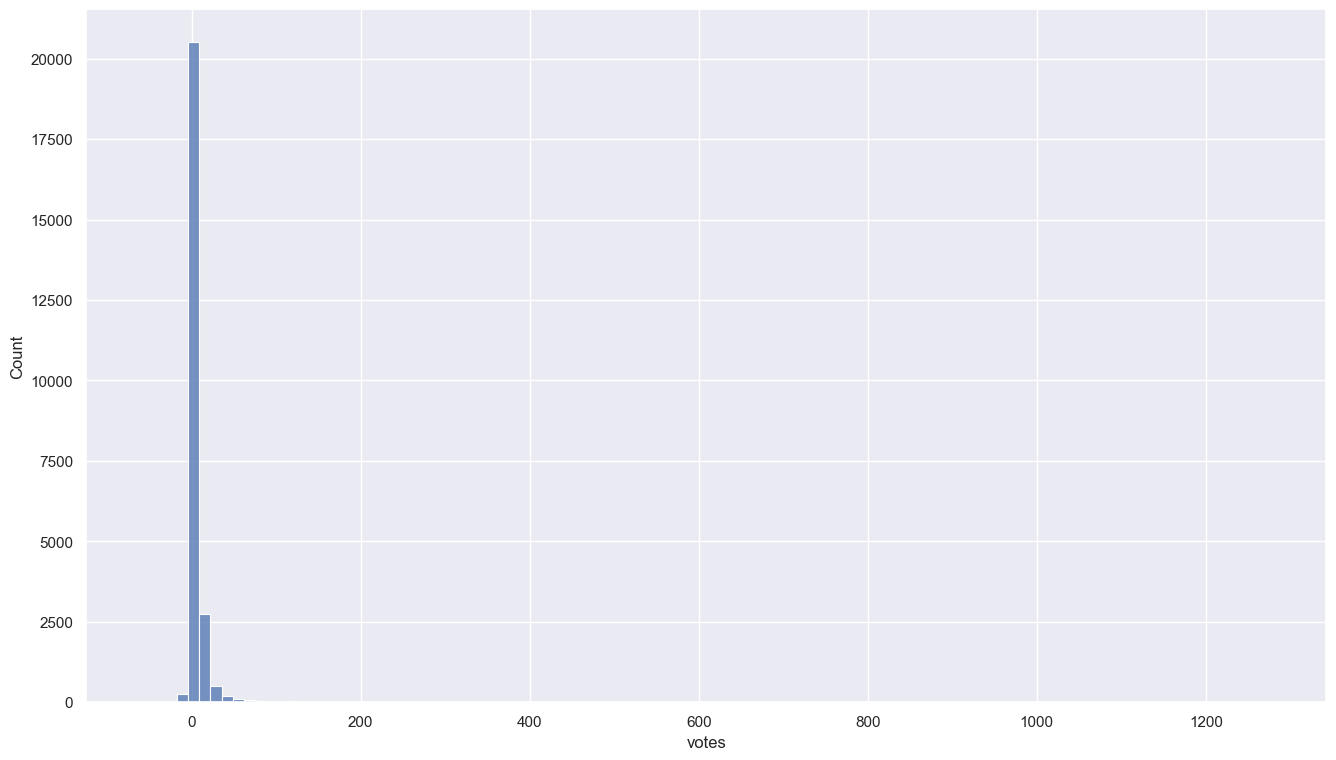

In [196]:
sns.histplot(data=df, x="votes", bins=100)

[(0.0, 100.0)]

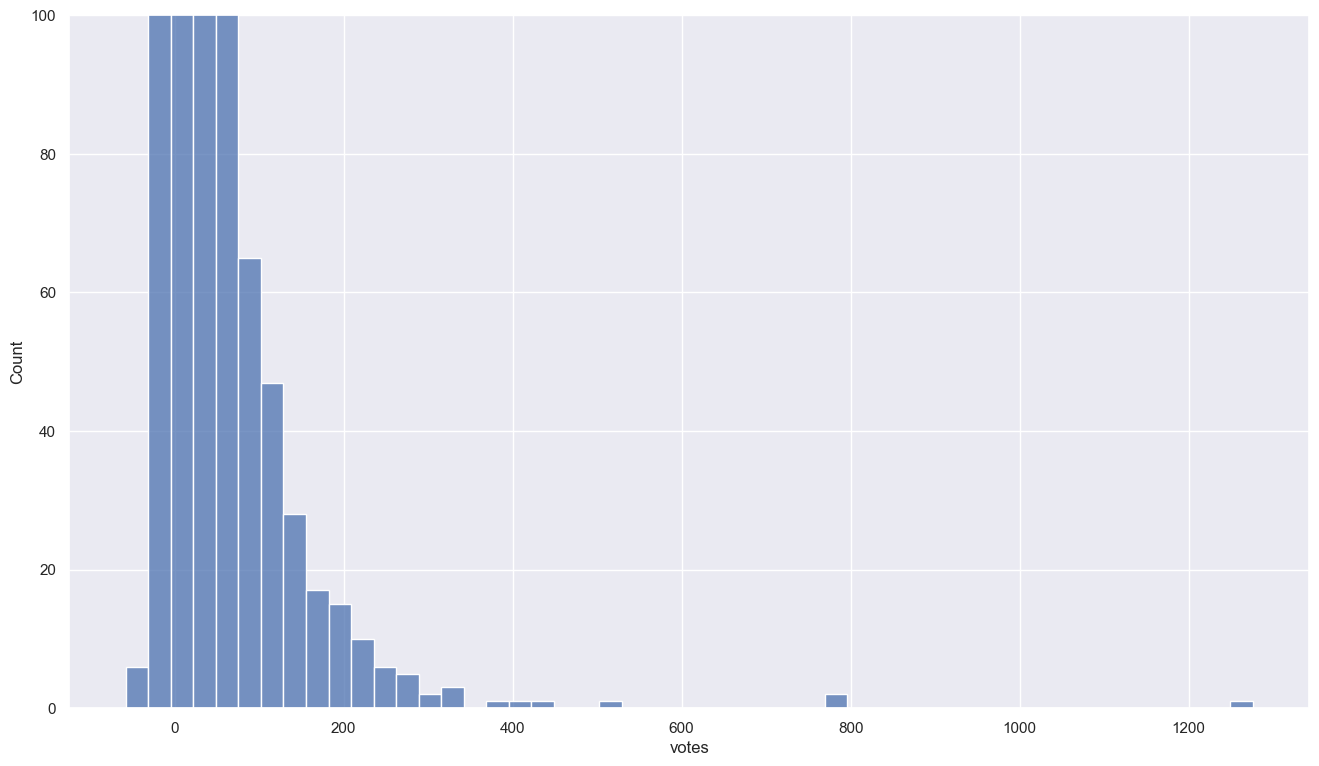

In [197]:
ax = sns.histplot(data=df, x="votes", bins=50)
ax.set(ylim=(0, 100))

In [198]:
print(f"99th quantile of votes: {df["votes"].quantile(0.99)}")

99th quantile of votes: 65.0


In [199]:
print(f"90th quantile of votes: {df["votes"].quantile(0.90)}")

90th quantile of votes: 12.0


### Признак created_timestamp

In [200]:
from datetime import datetime

In [201]:
df["created_datetime"] = df["created_timestamp"].apply(
    lambda x: datetime.fromtimestamp(x)
)

In [202]:
df["created_datetime"].min()

Timestamp('2012-09-18 20:40:11')

In [203]:
df["created_datetime"].max()

Timestamp('2023-06-10 11:42:20')

In [204]:
df["year"] = df["created_datetime"].apply(
    lambda x: x.year
)

In [205]:
df.groupby("year").size()

year
2012        8
2013       73
2014      108
2015       56
2016      197
2017      257
2018      553
2019     3042
2020     1718
2021     3758
2022    12337
2023     2499
dtype: int64

In [206]:
df.groupby("year")["votes"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2012,8.0,2.625000,1.597990,1.0,1.75,2.0,3.50,5.0
2013,73.0,2.808219,2.252514,-1.0,1.00,2.0,4.00,12.0
2014,108.0,2.990741,2.666845,0.0,1.00,2.0,4.00,13.0
2015,56.0,2.553571,3.044635,-6.0,1.00,2.0,3.25,11.0
2016,197.0,2.213198,2.772906,-4.0,1.00,2.0,3.00,23.0
2017,257.0,2.926070,3.379393,-6.0,1.00,2.0,3.00,24.0
2018,553.0,3.452080,5.405811,-12.0,1.00,2.0,3.00,57.0
2019,3042.0,4.072978,8.569921,-16.0,1.00,2.0,5.00,193.0
2020,1718.0,5.662980,14.417073,-23.0,1.00,2.0,5.00,226.0


In [3]:
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification, 
    pipeline
)

In [208]:
%env HF_HUB_DISABLE_SYMLINKS_WARNING=1

ner_name = "Babelscape/wikineural-multilingual-ner"
ner_tokenizer = AutoTokenizer.from_pretrained(ner_name)
ner_model = AutoModelForTokenClassification.from_pretrained(ner_name)
ner_pipe = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, grouped_entities=True)

env: HF_HUB_DISABLE_SYMLINKS_WARNING=1


c:\Users\artur\source\rra\venv\Lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [209]:
df["text_body"] = df["text_body"].fillna("")

In [210]:
df["named_entities"] = df["text_body"].progress_apply(
    lambda x: ner_pipe(x) if isinstance(x, str) else []
)

100%|██████████| 24606/24606 [28:58<00:00, 14.15it/s] 


In [4]:
class NumpyEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.floating):
            return float(obj)
        else:
            return super(NumpyEncoder, self).default(obj)

In [212]:
df["named_entities_json"] = df["named_entities"].apply(
    lambda x: dumps(x, cls=NumpyEncoder)
)

In [5]:
def build_replies_up_pos(df: pd.DataFrame, starting_node: tuple[str]) -> list[str]:
    out = [starting_node[1]]
    next_parent = starting_node[2]

    while not pd.isna(next_parent):
        node = df[df["full_name"] == next_parent]
        out.append(str(node.iloc[0]['text_body']))
        next_parent = node.iloc[0]['responds_to']

    return list(reversed(out))

In [214]:
df["full_text"] = df.apply(
    lambda x: " ".join(build_replies_up_pos(df, (x["full_name"], x["text_body"], x["responds_to"]))),
    axis=1
)

In [215]:
df.to_csv("kw/ner_full_text.csv", index=False)

In [216]:
%env HF_HUB_DISABLE_SYMLINKS_WARNING=1

emotion_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_name)
emotion_pipe = pipeline("text-classification", model=emotion_model, tokenizer=emotion_tokenizer, return_all_scores=True)

env: HF_HUB_DISABLE_SYMLINKS_WARNING=1


c:\Users\artur\source\rra\venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
def emotional_exponential_average(source_text, model, sampling_size = 500, sampling_step = 100, momentum = 0.8):

    # If 4-byte UTF-8 characters are present - make smaller steps to fit text into tokenizer window
    if len(source_text[:sampling_size].encode()) > 500:
        sampling_size = min(sampling_size // 4, 100)
        sampling_step = min(sampling_step // 4, 20)

    moving_average = None
    try:
        moving_average = model(source_text[:sampling_size])[0]
    except RuntimeError:
        return None

    for i in range(sampling_step, len(source_text) - sampling_size, sampling_step):
        try:
            prediction = model(source_text[i:i + sampling_size])[0]
        except RuntimeError:
            return None

        for average, current in zip(moving_average, prediction):
            average["score"] = momentum * average["score"] + (1 - momentum) * current["score"]

    return moving_average

In [218]:
df["emotion"] = df["full_text"].progress_apply(
    lambda x: emotional_exponential_average(x, emotion_pipe)
)

100%|██████████| 24606/24606 [2:18:45<00:00,  2.96it/s]   


In [219]:
df.to_csv("kw/ner_full_text_emotion.csv", index=False)

In [220]:
df.head()

,full_name,text_body,author_name,votes,responds_to,parent_submission_name,submission_flair,created_timestamp,parsed_timestamp,controversiality,created_datetime,year,named_entities,named_entities_json,full_text,emotion
0,t3_un1z9w,Sri Lankan opposition leader Sajith Premadasa ...,t2_63oe5kpm,179,NaN,t3_un1z9w,NaN,1.652245e+09,1731353678,False,2022-05-11 12:03:15,2022,"[{'entity_group': 'PER', 'score': 0.99757975, ...","[{""entity_group"": ""PER"", ""score"": 0.9975797533...",Sri Lankan opposition leader Sajith Premadasa ...,"[{'label': 'anger', 'score': 0.201455861330032..."
1,t1_i868ljo,Look at this dudes car !! Has he ever had a jo...,NaN,36,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,[],[],Sri Lankan opposition leader Sajith Premadasa ...,"[{'label': 'anger', 'score': 0.207774564623832..."
2,t1_i86ogbn,Anyone with half a brain knows this guy is a p...,t2_96ecn1c5,26,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{'entity_group': 'ORG', 'score': 0.79692316, ...","[{""entity_group"": ""ORG"", ""score"": 0.7969231605...",Sri Lankan opposition leader Sajith Premadasa ...,"[{'label': 'anger', 'score': 0.164950283700237..."
3,t1_i85t3da,Why is there some blind arab man trying to cro...,t2_8ctz6ggl,43,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{'entity_group': 'MISC', 'score': 0.92525345,...","[{""entity_group"": ""MISC"", ""score"": 0.925253450...",Sri Lankan opposition leader Sajith Premadasa ...,"[{'label': 'anger', 'score': 0.151034057140350..."
4,t1_i85mb6t,/r/praisethecameraman,t2_684r0o1z,23,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{'entity_group': 'MISC', 'score': 0.5501193, ...","[{""entity_group"": ""MISC"", ""score"": 0.550119280...",Sri Lankan opposition leader Sajith Premadasa ...,"[{'label': 'anger', 'score': 0.250387310981750..."


In [221]:
df["emotion_json"] = df["emotion"].apply(
    lambda x: dumps(x, cls=NumpyEncoder)
)

In [222]:
df.to_csv("kw/ner_full_text_emotion_json.csv", index=False)

In [5]:
df = pd.read_csv("ner_emotion_analysis_1.csv")

In [6]:
df.head()

,full_name,text_body,author_name,votes,responds_to,parent_submission_name,submission_flair,created_timestamp,parsed_timestamp,controversiality,created_datetime,year,named_entities_json,full_text,emotion_json
0,t3_un1z9w,Sri Lankan opposition leader Sajith Premadasa ...,t2_63oe5kpm,179,NaN,t3_un1z9w,NaN,1.652245e+09,1731353678,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""PER"", ""score"": 0.9975797533...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.201455861330032..."
1,t1_i868ljo,Look at this dudes car !! Has he ever had a jo...,NaN,36,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,[],Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.207774564623832..."
2,t1_i86ogbn,Anyone with half a brain knows this guy is a p...,t2_96ecn1c5,26,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""ORG"", ""score"": 0.7969231605...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.164950283700237..."
3,t1_i85t3da,Why is there some blind arab man trying to cro...,t2_8ctz6ggl,43,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""MISC"", ""score"": 0.925253450...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.151034057140350..."
4,t1_i85mb6t,/r/praisethecameraman,t2_684r0o1z,23,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""MISC"", ""score"": 0.550119280...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.250387310981750..."


In [7]:
df = pd.read_csv("ner_emotion_analysis_1.csv")

df["named_entities"] = df["named_entities_json"].apply(
    lambda x: loads(x)
)

In [8]:
df["emotion"] = df["emotion_json"].apply(
    lambda x: loads(x)
)

In [9]:
entity_list = []


def extract_entities(row):
    for entity_dict in row:
        entity_list.append(entity_dict["word"])


df["named_entities"].apply(
    extract_entities
)

print(f"List length: {len(entity_list)}")
print(f"Set length: {len(set(entity_list))}")

List length: 36849
Set length: 10588


In [10]:
entity_emotion = {}


def row_to_dict(row):
    ent, emo = row

    for ent_dict in ent:
        named_entity = ent_dict["word"]
        emotions_list = entity_emotion.get(named_entity)
        
        if not emo:
            continue

        emotion_vector = [emotion_dict["score"] for emotion_dict in emo]
        
        if emotions_list:
            emotions_list.append(emotion_vector)
        else:
            entity_emotion[named_entity] = [emotion_vector]


df[["named_entities", "emotion"]].apply(
    row_to_dict,
    axis=1
)

0        None
1        None
2        None
3        None
4        None
         ... 
24601    None
24602    None
24603    None
24604    None
24605    None
Length: 24606, dtype: object

In [11]:
emotion_stats = {
    "anger": [],
    "disgust": [],
    "fear": [],
    "joy": [],
    "neutral": [],
    "sadness": [],
    "surprise": []
}


def extract_emotion(row):
    for emotion_dict in row:
        key = emotion_dict["label"]
        value = emotion_dict["score"]

        emotion_stats[key].append(value)


df["emotion"].progress_apply(
    extract_emotion
)


emotion_stats_df = pd.DataFrame.from_dict(emotion_stats)

100%|██████████| 24606/24606 [00:00<00:00, 698048.29it/s]


In [12]:
emotion_stats_df.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise
count,24606.000000,24606.000000,24606.000000,24606.000000,24606.000000,24606.000000,24606.000000
mean,0.137031,0.082691,0.103906,0.063679,0.402317,0.084208,0.126169
std,0.204582,0.152045,0.191681,0.154578,0.299481,0.164734,0.185326
min,0.000570,0.000158,0.000213,0.000244,0.000326,0.000820,0.000343
25%,0.012419,0.006093,0.006567,0.003812,0.114586,0.011265,0.016212
50%,0.041513,0.020761,0.023259,0.009171,0.366738,0.024627,0.049788
75%,0.166300,0.082122,0.095823,0.034110,0.671362,0.068052,0.148795
max,0.989281,0.990443,0.993502,0.989890,0.971468,0.988969,0.984274


<Axes: >

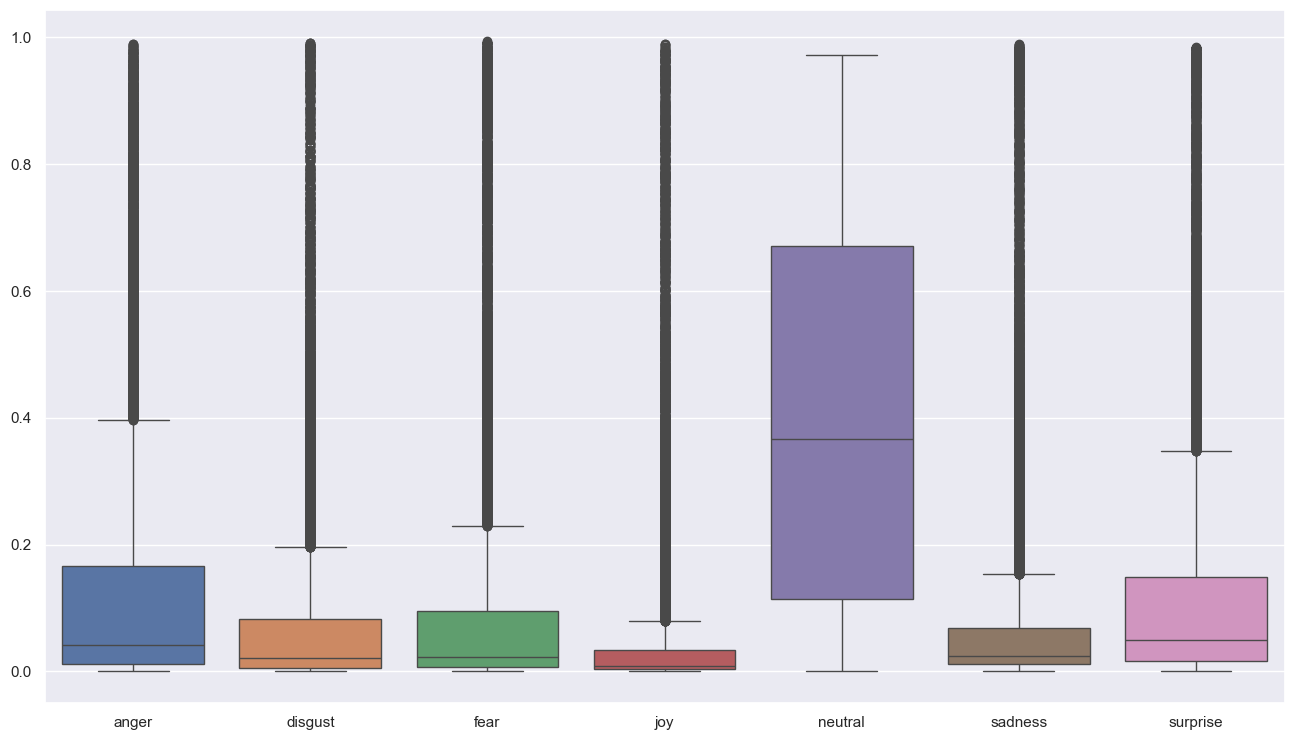

In [13]:
sns.boxplot(data = emotion_stats_df)

In [14]:
entity_emotion_divergence = {}


for k, v in entity_emotion.items():
    if len(v) < 2:
        continue

    simmilarity_of_all_pairs = []

    for i in range(len(v)):
        for j in range(i + 1, len(v)):
            simmilarity_of_all_pairs.append(
                np.dot(v[i], v[j]) / (np.linalg.norm(v[i]) * np.linalg.norm(v[j]))
            )

    entity_emotion_divergence[k] = float(np.mean(simmilarity_of_all_pairs))

In [15]:
sorted_entity_emotion_divergence = sorted(
    entity_emotion_divergence.items(),
    key=lambda x: x[1],
    reverse=True
)

In [16]:
sorted_divergence = list(
    map(
        lambda x: x[1],
        sorted_entity_emotion_divergence
    )
)

<Axes: ylabel='Count'>

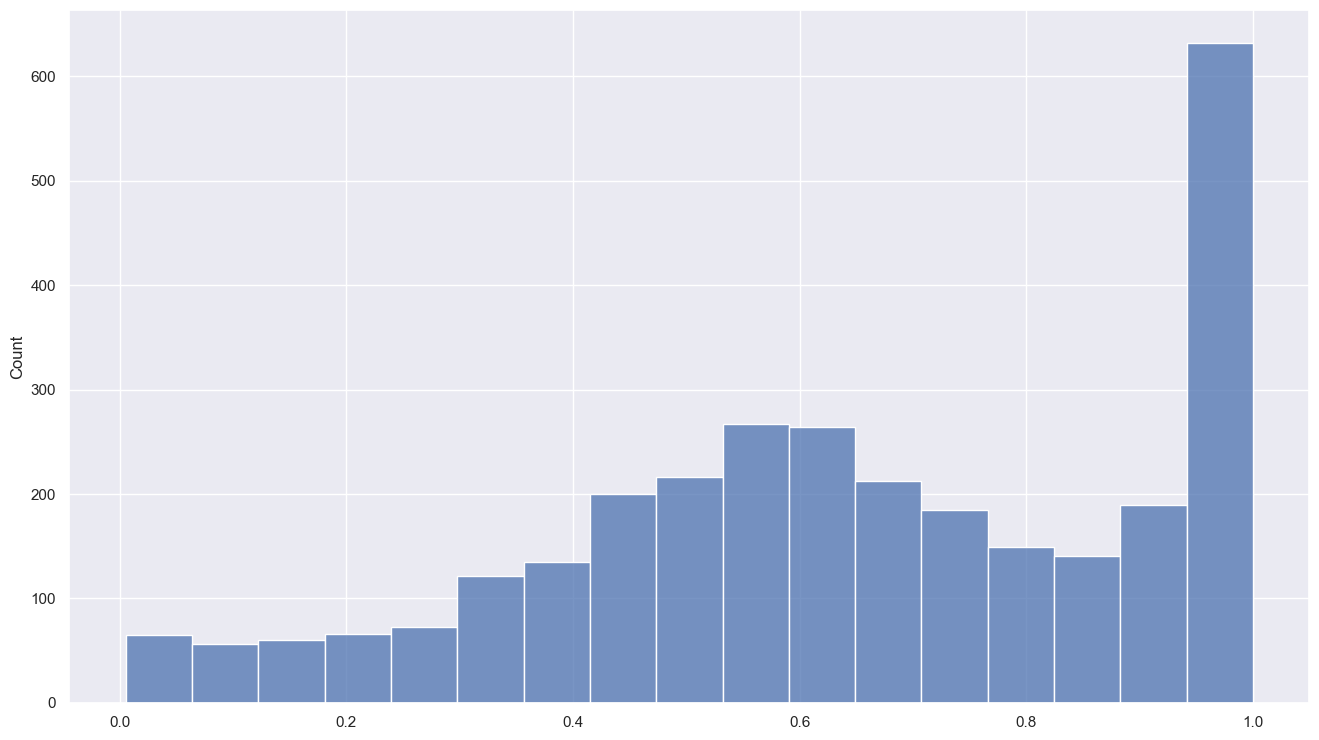

In [17]:
sns.histplot(x=sorted_divergence)

In [18]:
len(sorted_divergence)

3031

In [19]:
list(reversed(sorted_entity_emotion_divergence))

[('Bezos', 0.005258243218093349),
 ('Land Cruiser', 0.006228463070122065),
 ('Stay safe', 0.0072870550992304136),
 ('Shu', 0.012723031034506121),
 ('white', 0.013502808859584839),
 ('##eed', 0.013620668845786124),
 ('ja', 0.014053610960810233),
 ('##rypto', 0.014926553095428155),
 ('sajith', 0.015504935346104594),
 ('Power Cut', 0.018552658888554088),
 ('Sing', 0.019558852215937266),
 ('sub', 0.019766392721197956),
 ("St. Anthony ' s", 0.020610299249294688),
 ('Comment', 0.020918822761118436),
 ('University of Peradeniya', 0.02099803214003547),
 ('Art', 0.02128840802639949),
 ('Friendly', 0.022090147622160213),
 ('Udaya', 0.02337634794588717),
 ('Be', 0.023769525631767364),
 ('Con', 0.025773509054626373),
 ('Kudos', 0.02742702841578997),
 ("St. Anthony ' s Church", 0.028242008279392373),
 ('aw', 0.030100647932530967),
 ('ins', 0.03036497890743093),
 ('St. Anthony ’ s Church', 0.031578903918343025),
 ('##abaya', 0.03162926401813412),
 ('1910', 0.031946786673362204),
 ('##SL', 0.03435381

In [20]:
df.head()

,full_name,text_body,author_name,votes,responds_to,parent_submission_name,submission_flair,created_timestamp,parsed_timestamp,controversiality,created_datetime,year,named_entities_json,full_text,emotion_json,named_entities,emotion
0,t3_un1z9w,Sri Lankan opposition leader Sajith Premadasa ...,t2_63oe5kpm,179,NaN,t3_un1z9w,NaN,1.652245e+09,1731353678,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""PER"", ""score"": 0.9975797533...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.201455861330032...","[{'entity_group': 'PER', 'score': 0.9975797533...","[{'label': 'anger', 'score': 0.201455861330032..."
1,t1_i868ljo,Look at this dudes car !! Has he ever had a jo...,NaN,36,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,[],Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.207774564623832...",[],"[{'label': 'anger', 'score': 0.207774564623832..."
2,t1_i86ogbn,Anyone with half a brain knows this guy is a p...,t2_96ecn1c5,26,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""ORG"", ""score"": 0.7969231605...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.164950283700237...","[{'entity_group': 'ORG', 'score': 0.7969231605...","[{'label': 'anger', 'score': 0.164950283700237..."
3,t1_i85t3da,Why is there some blind arab man trying to cro...,t2_8ctz6ggl,43,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""MISC"", ""score"": 0.925253450...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.151034057140350...","[{'entity_group': 'MISC', 'score': 0.925253450...","[{'label': 'anger', 'score': 0.151034057140350..."
4,t1_i85mb6t,/r/praisethecameraman,t2_684r0o1z,23,t3_un1z9w,t3_un1z9w,NaN,1.652245e+09,1731353680,False,2022-05-11 12:03:15,2022,"[{""entity_group"": ""MISC"", ""score"": 0.550119280...",Sri Lankan opposition leader Sajith Premadasa ...,"[{""label"": ""anger"", ""score"": 0.250387310981750...","[{'entity_group': 'MISC', 'score': 0.550119280...","[{'label': 'anger', 'score': 0.250387310981750..."


In [237]:
df.to_csv("kw/ner_emotion_analysis.csv", index=False, columns=[
    "full_name",
    "text_body",
    "author_name",
    "votes",
    "responds_to",
    "parent_submission_name",
    "submission_flair",
    "created_timestamp",
    "parsed_timestamp",
    "controversiality",
    "created_datetime",
    "year",
    "named_entities_json",
    "full_text",
    "emotion_json"
])

Virtual Insanity

In [21]:
df_disec = pd.read_csv("ner_emotion_analysis_1.csv")

In [22]:
df_disec.iloc[0]["named_entities_json"]

'[{"entity_group": "PER", "score": 0.9975797533988953, "word": "Sajith Premadasa", "start": 29, "end": 45}, {"entity_group": "LOC", "score": 0.9972994923591614, "word": "Gotagogama", "start": 80, "end": 90}, {"entity_group": "LOC", "score": 0.9996416568756104, "word": "Colombo", "start": 92, "end": 99}, {"entity_group": "LOC", "score": 0.999639630317688, "word": "Sri Lanka", "start": 101, "end": 110}, {"entity_group": "PER", "score": 0.990755558013916, "word": "Tharak Basnayaka", "start": 129, "end": 145}]'

In [23]:
def save_values_to(named_entities_json: str) -> set:
    entities = set()
    for i in loads(named_entities_json):
        entities.add(i["word"])
    return entities

disec_entites = set()
for i in df_disec["named_entities_json"]:
    disec_entites.update(save_values_to(i))
print(len(disec_entites))

10588


In [24]:
len(sorted_entity_emotion_divergence)

3031

In [25]:
frequencies = {}
for i in sorted_entity_emotion_divergence:
    if( i[0] in disec_entites and i[1] <= 0.70):
        frequencies.update({i[0] : pow(i[1], -1)})

print(len(frequencies),frequencies)

1715 {'Bangalore': 1.4289486793958686, 'Korea': 1.4299727730601348, 'Hong Kong': 1.4300858742489302, 'Northern province': 1.430160113334825, 'JPMorgan': 1.4306261261403985, 'Source': 1.43188371312243, 'Ka': 1.433811280869116, 'Na': 1.4341979987084514, 'Calgary': 1.434377410446343, 'Burkas': 1.4348462073270194, 'Unawatuna': 1.4356718135703483, 'Melbourne': 1.4361791084170685, 'Re': 1.4362748416617863, 'Mount Lavinia': 1.4363161977278156, 'North Indian': 1.4363861671319647, 'Raffles': 1.4365663724305897, 'Off': 1.4365746647016715, '/': 1.4367140122188304, 'the': 1.4375051525806457, 'Panadura': 1.4380665226468998, 'Kapruka': 1.4386662909067762, 'PickMe': 1.4388042337008358, 'Fiji': 1.4388125864808161, 'Gold': 1.440006642178457, 'Gateway': 1.4416287000448698, 'Aeroflot': 1.4429510186951255, 'AKD': 1.4434877643130966, 'Isis': 1.4443339166577345, 'Johnny': 1.4451191212146632, 'Yeap': 1.4456091231822352, 'Exynos': 1.4468013539059112, 'Ass': 1.4469769118014144, 'State': 1.447084585674613, '##h

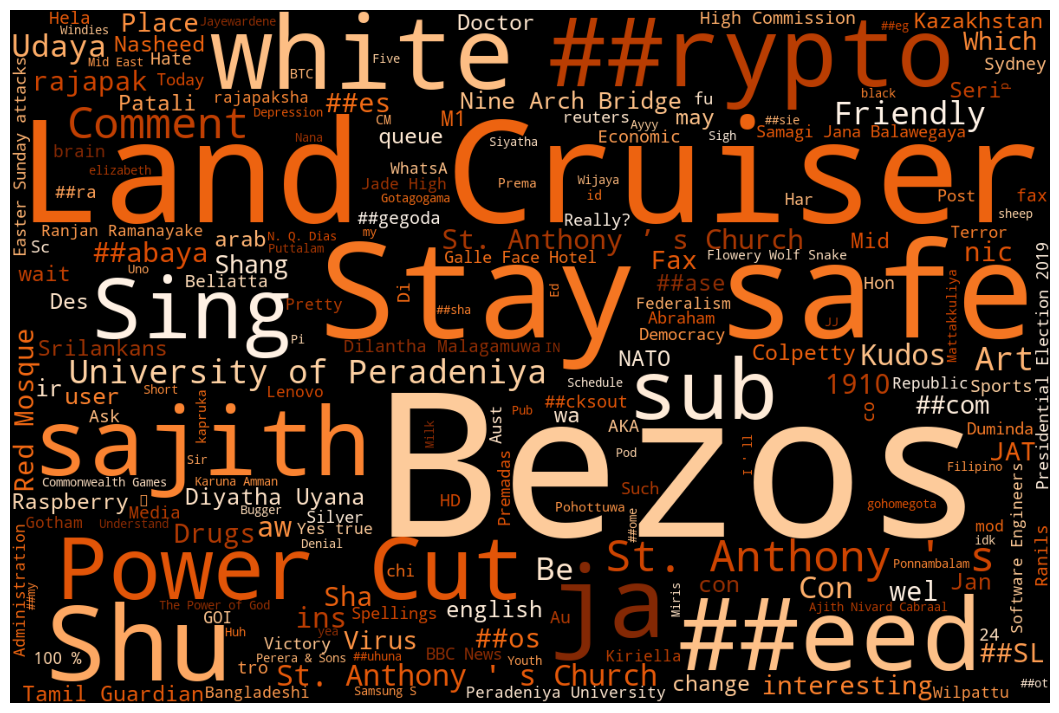

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(width=1200,
                      height=800,
                      background_color='black',
                      stopwords=set(),
                      colormap='Oranges_r').generate_from_frequencies(frequencies)

plt.axis("off")
plt.imshow(wordcloud)

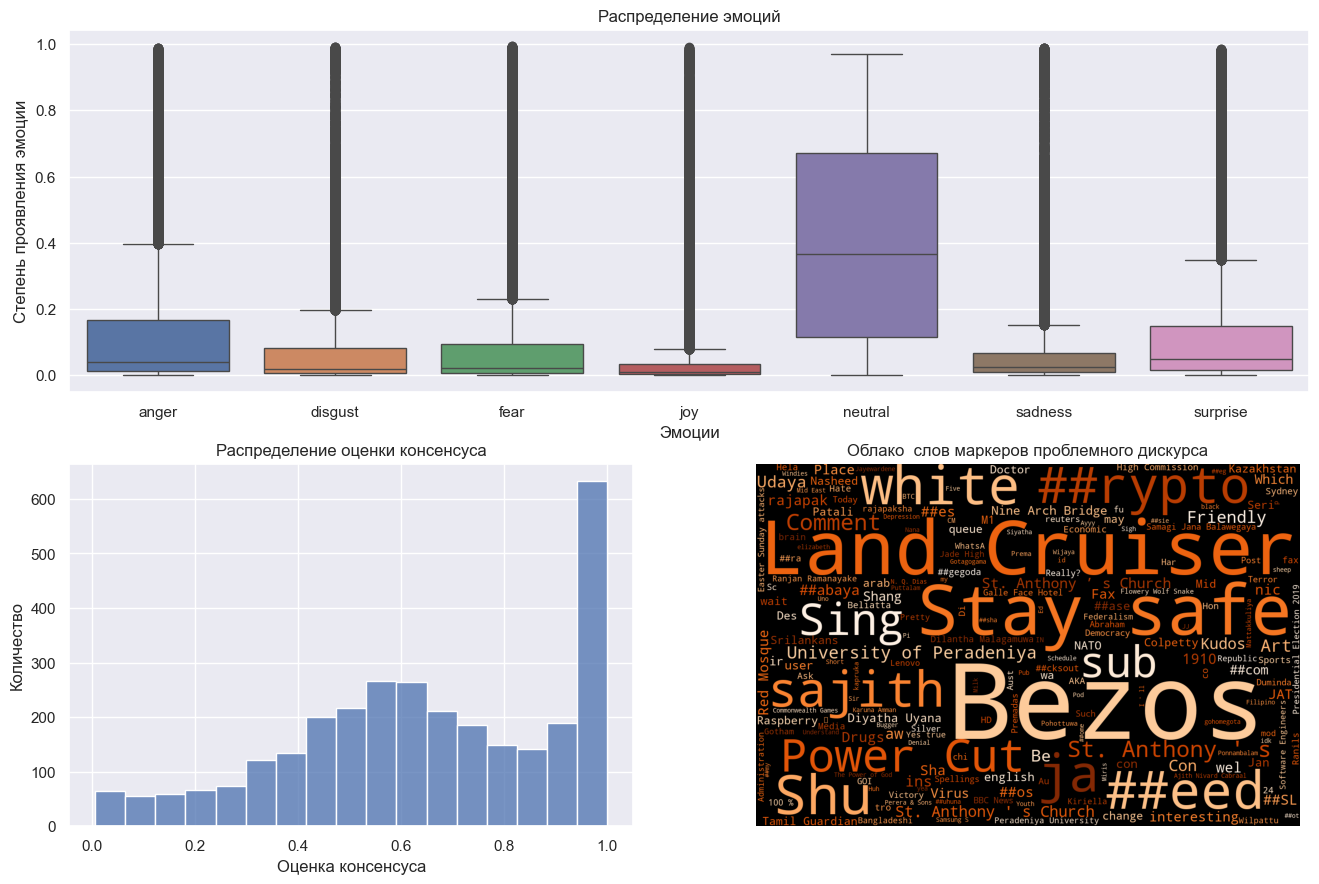

In [53]:
fig = plt.figure()
fig.subplots_adjust(
    left  = 0.125,  
    right = 0.9,   
    bottom = 0.1,   
    top = 0.985,
    wspace = 0.2,   
    hspace = 0.2,   
)
axes = fig.subplot_mosaic(
    [['Top', 'Top'],
     ['Bottom_R', 'Bottom_L']],
    gridspec_kw={'width_ratios':[2, 2]}
)

axes['Top'].title.set_text('Распределение эмоций')
axes['Top'].set_xlabel('Эмоции')
axes['Top'].set_ylabel('Степень проявления эмоции')
sns.boxplot(ax = axes['Top'], data = emotion_stats_df)

axes['Bottom_R'].title.set_text('Распределение оценки консенсуса')
axes['Bottom_R'].set_xlabel('Оценка консенсуса')
axes['Bottom_R'].set_ylabel('Количество')
sns.histplot(ax = axes['Bottom_R'], x=sorted_divergence)

axes['Bottom_L'].title.set_text('Облако  слов маркеров проблемного дискурса')
axes['Bottom_L'].axis("off")
axes['Bottom_L'].imshow(wordcloud)